# GCN model with smaller data set

In [2]:
# General libraries
import json
from pathlib import Path as Data_Path
import os
from os.path import isfile, join
import pickle
import random

import numpy as np
import networkx as nx
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [3]:
# Import relevant ML libraries
from typing import Optional, Union

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor

print(f"Torch version: {torch.__version__}; Torch-cuda version: {torch.version.cuda}; Torch Geometric version: {torch_geometric.__version__}.")

Torch version: 2.2.1; Torch-cuda version: None; Torch Geometric version: 2.5.1.


We also set a random seed so that our work is reproducible!

In [ ]:
# set the seed for reproducibility
seed = 224
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Loading and processing data

In [6]:
data = pd.read_csv('../Data/user_songs_filtered.csv')

In [8]:
data = data.sort_values(by = 'Username')
data = data.reset_index(drop=True)
data

Username country  registered_year  track_count  artist_count  \
0        -itssoeasy  Brazil             2010         4350           418   
1        -itssoeasy  Brazil             2010         4350           418   
2        -itssoeasy  Brazil             2010         4350           418   
3        -itssoeasy  Brazil             2010         4350           418   
4        -itssoeasy  Brazil             2010         4350           418   
...             ...     ...              ...          ...           ...   
173594  zzakkkkkkkk  Poland             2018        16920          2978   
173595  zzakkkkkkkk  Poland             2018        16920          2978   
173596  zzakkkkkkkk  Poland             2018        16920          2978   
173597  zzakkkkkkkk  Poland             2018        16920          2978   
173598  zzakkkkkkkk  Poland             2018        16920          2978   

                        track_name      artist_name  rank  playcount  \
0       Kiara Rocks - Pode Apostar      Kiara Rocks    29         22   
1                       Anna Molly          Incubus     3         45   
2              Breakin' the Chainz        CRASHDÏET    28         22   
3                     Act Appalled    Circa Survive     2         55   
4                      Wish Resign    Circa Survive    42         18   
...                            ...              ...   ...        ...   
173594                   Flatlands    Chelsea Wolfe    28         52   
173595           Rest My Chemistry         Interpol    13         56   
173596            The Past Recedes  John Frusciante    41         47   
173597            Fire of the Mind             Coil    32         49   
173598                    Untitled         Interpol    48         46   

                                                   lyrics  ...  emotion1  \
0       \ndoodoo doo doodoodoo\ndoodoo doo doodoodoo\n...  ...  positive   
1       a cloud hangs over this city by the sea\ni wat...  ...      fear   
2       \nthe trick of turnin bricks to gold\nthe lick...  ...  negative   
3       you walk straight not like them\nto fool them ...  ...  negative   
4       alter and teach the ages\nnothing you love las...  ...  positive   
...                                                   ...  ...       ...   
173594  i want flatlands\ni never cared about money an...  ...   sadness   
173595  i havent slept for two days\nive bathed in not...  ...  positive   
173596  one two three four\n\n \nand then the past rec...  ...  positive   
173597  or with eager reinforcements\ndoes death come ...  ...  positive   
173598  \nsurprise sometimes will come around\nsurpris...  ...      fear   

        emotion1_score  emotion2 emotion2_score  \
0             0.136923  negative       0.066923   
1             0.132121  negative       0.091429   
2             0.048868   sadness       0.041878   
3             0.194122  positive       0.107557   
4             0.185449  negative       0.078462   
...                ...       ...            ...   
173594        0.095979  surprise       0.043816   
173595        0.352539      fear       0.098052   
173596        0.182978  negative       0.134921   
173597        0.260699     trust       0.093952   
173598        0.194237  positive       0.154264   

                                                     mfcc  \
0       [-30.417461   138.31747    -62.222576    53.44...   
1       [-3.17496109e+01  1.22686035e+02 -5.40179520e+...   
2       [-85.5819    139.433     -54.177013   46.21956...   
3       [-64.35698   143.57889   -47.672024   58.13195...   
4       [-65.22894    148.37325    -52.359398    53.93...   
...                                                   ...   
173594  [-259.8826     187.17397      3.1883478   35.9...   
173595  [-112.32704    175.54272    -53.33165     39.7...   
173596  [-1.5667607e+02  1.8335361e+02 -3.5247272e+01 ...   
173597  [-41.360065  147.68622   -65.31051    53.63539...   
173598  [-80.47788    157.25774    -45.948483   

In [16]:
# build on a subset of model
data_subset = data.loc[data.Username <= 'SierraWuff']
data_subset

Username  country  registered_year  track_count  artist_count  \
0      -itssoeasy   Brazil             2010         4350           418   
1      -itssoeasy   Brazil             2010         4350           418   
2      -itssoeasy   Brazil             2010         4350           418   
3      -itssoeasy   Brazil             2010         4350           418   
4      -itssoeasy   Brazil             2010         4350           418   
...           ...      ...              ...          ...           ...   
49991  SierraWuff  Unknown             2020         3263           784   
49992  SierraWuff  Unknown             2020         3263           784   
49993  SierraWuff  Unknown             2020         3263           784   
49994  SierraWuff  Unknown             2020         3263           784   
49995  SierraWuff  Unknown             2020         3263           784   

                       track_name    artist_name  rank  playcount  \
0      Kiara Rocks - Pode Apostar    Kiara Rocks    29         22   
1                      Anna Molly        Incubus     3         45   
2             Breakin' the Chainz      CRASHDÏET    28         22   
3                    Act Appalled  Circa Survive     2         55   
4                     Wish Resign  Circa Survive    42         18   
...                           ...            ...   ...        ...   
49991                     Tap Out    The Strokes    27         65   
49992                    Reptilia    The Strokes    39         60   
49993      Two Kinds of Happiness    The Strokes    14         69   
49994                    QYURRYUS      The Voidz    22         67   
49995            Ize of the World    The Strokes    18         68   

                                                  lyrics  ...  emotion1  \
0      \ndoodoo doo doodoodoo\ndoodoo doo doodoodoo\n...  ...  positive   
1      a cloud hangs over this city by the sea\ni wat...  ...      fear   
2      \nthe trick of turnin bricks to gold\nthe lick...  ...  negative   
3      you walk straight not like them\nto fool them ...  ...  negative   
4      alter and teach the ages\nnothing you love las...  ...  positive   
...                                                  ...  ...       ...   
49991  they found our city under the water\ngotta get...  ...  negative   
49992  he seemed impressed by the way you came in\nte...  ...  negative   
49993  happiness is two different things\nwhat you ta...  ...  negative   
49994  hot track hot dress\nundressing this hot mess\...  ...  negative   
49995  i think i know what you mean but watch what yo...  ...   sadness   

       emotion1_score  emotion2 emotion2_score  \
0            0.136923  negative       0.066923   
1            0.132121  negative       0.091429   
2            0.048868   sadness       0.041878   
3            0.194122  positive       0.107557   
4            0.185449  negative       0.078462   
...               ...       ...            ...   
49991        0.048447      fear       0.047451   
49992        0.143841  positive       0.073846   
49993        0.125063  positive       0.090546   
49994        0.170773   sadness       0.142967   
49995        0.087849  negative       0.085889   

                                                    mfcc  \
0      [-30.417461   138.31747    -62.222576    53.44...   
1      [-3.17496109e+01  1.22686035e+02 -5.40179520e+...   
2      [-85.5819    139.433     -54.177013   46.21956...   
3      [-64.35698   143.57889   -47.672024   58.13195...   
4      [-65.22894    148.37325    -52.359398    53.93...   
...                                                  ...   
49991  [-87.461464  128.73668   -45.950912   56.24657...   
49992  [-6.3067352e+01  1.3085684e+02 -3.3576553e+01 ...   
49993  [-46.300518  133.09387   -51.512      71.42351...   
49994  [-9.76260529e+01  1.82377838e+02 -2.35133057e+...   
49995  [-159.15466     207.19919     -34.682823     1...   

                                                  chroma       rms  

In [15]:
data_subset.Username.nunique()

1629

Now let's get ready to load in our data. First, we define a few simple, helfpul classes.

In [95]:
class Track:
  def __init__(self, track_dict):
    self.name = track_dict["track_name"]
    self.artist_name = track_dict["artist_name"]
    self.listeners = track_dict["listeners"]
    self.total_playcount = track_dict["total_playcount"]
    self.emotion1 = track_dict["emotion1"]
    self.emotion1_score = track_dict["emotion1_score"]
    self.emotion2 = track_dict["emotion2"]
    self.emotion2_score = track_dict["emotion2_score"]
    self.rms = track_dict["rms"]
    self.spectral_centroid	= track_dict['spectral_centroid']
    self.tempo = track_dict['tempo']

  def __str__(self):
    return f"Track called {self.name} by ({self.artist_name}) has emotions {self.emotion1} and {self.emotion2}."

  def __repr__(self):
    return f"Track {self.name}"

  def __lt__(self, other):
    return (self.name < other.name) and (self.total_playcount < other.total_playcount)

  def __gt__(self, other):
    return (self.name > other.name) and (self.total_playcount > other.total_playcount)


In [21]:
data_subset.track_name.nunique()

25563

In [25]:
data_subset[['track_name', 'artist_name']].drop_duplicates().to_numpy()


array(['Kiara Rocks - Pode Apostar', 'Kiara Rocks'], dtype=object)

In [19]:
data_subset.loc[data_subset['track_name'] == 'Anna Molly']

Username country  registered_year  track_count  artist_count  \
1     -itssoeasy  Brazil             2010         4350           418   
8565     CahYumi  Brazil             2007        29605          6740   

      track_name artist_name  rank  playcount  \
1     Anna Molly     Incubus     3         45   
8565  Anna Molly     Incubus    42        156   

                                                 lyrics  ...  emotion1  \
1     a cloud hangs over this city by the sea\ni wat...  ...      fear   
8565  a cloud hangs over this city by the sea\ni wat...  ...      fear   

      emotion1_score  emotion2 emotion2_score  \
1           0.132121  negative       0.091429   
8565        0.132121  negative       0.091429   

                                                   mfcc  \
1     [-3.17496109e+01  1.22686035e+02 -5.40179520e+...   
8565  [-3.17496109e+01  1.22686035e+02 -5.40179520e+...   

                                                 chroma       rms  \
1     [0.5516333  0.5345342  0.5744656  0.55793136 0...  0.284177   
8565  [0.5516333  0.5345342  0.5744656  0.55793136 0...  0.284177   

     spectral_centroid       zcr     tempo  
1          3672.541142  0.098563  75.99954  
8565       3672.541142  0.098563  75.99954  

[2 rows x 27 columns]

In [38]:
data_subset.loc[data_subset['Username'] == '-itssoeasy']

Username country  registered_year  track_count  artist_count  \
0   -itssoeasy  Brazil             2010         4350           418   
1   -itssoeasy  Brazil             2010         4350           418   
2   -itssoeasy  Brazil             2010         4350           418   
3   -itssoeasy  Brazil             2010         4350           418   
4   -itssoeasy  Brazil             2010         4350           418   
5   -itssoeasy  Brazil             2010         4350           418   
6   -itssoeasy  Brazil             2010         4350           418   
7   -itssoeasy  Brazil             2010         4350           418   
8   -itssoeasy  Brazil             2010         4350           418   
9   -itssoeasy  Brazil             2010         4350           418   
10  -itssoeasy  Brazil             2010         4350           418   
11  -itssoeasy  Brazil             2010         4350           418   
12  -itssoeasy  Brazil             2010         4350           418   
13  -itssoeasy  Brazil             2010         4350           418   
14  -itssoeasy  Brazil             2010         4350           418   
15  -itssoeasy  Brazil             2010         4350           418   
16  -itssoeasy  Brazil             2010         4350           418   
17  -itssoeasy  Brazil             2010         4350           418   
18  -itssoeasy  Brazil             2010         4350           418   
19  -itssoeasy  Brazil             2010         4350           418   
20  -itssoeasy  Brazil             2010         4350           418   
21  -itssoeasy  Brazil             2010         4350           418   
22  -itssoeasy  Brazil             2010         4350           418   
23  -itssoeasy  Brazil             2010         4350           418   
24  -itssoeasy  Brazil             2010         4350           418   
25  -itssoeasy  Brazil             2010         4350           418   
26  -itssoeasy  Brazil             2010         4350           418   
27  -itssoeasy  Brazil             2010         4350           418   
28  -itssoeasy  Brazil             2010         4350           418   
29  -itssoeasy  Brazil             2010         4350           418   

                            track_name        artist_name  rank  playcount  \
0           Kiara Rocks - Pode Apostar        Kiara Rocks    29         22   
1                           Anna Molly            Incubus     3         45   
2                  Breakin' the Chainz          CRASHDÏET    28         22   
3                         Act Appalled      Circa Survive     2         55   
4                          Wish Resign      Circa Survive    42         18   
5                           Situations    Escape the Fate    48         17   
6                          Are You In?            Incubus    14         28   
7                     The Greatest Lie      Circa Survive     9         33   
8                       Rose of Sharyn  Killswitch Engage    21         25   
9          Holding Someone's Hair Back      Circa Survive    24         23   
10               The Great Golden Baby      Circa Survive    31         21   
11                          Love Hurts            Incubus     4         45   
12                  Forgive And Forget         Miss May I    32         21   
13                           Heartburn         Architects    23         23   
14                    Nice to Know You            Incubus    13         29   
15                     Generation Wild          Crashdiet    47         17   
16          Kiara Rocks - Falso Alarme        Kiara Rocks    20         25   
17  Kiara Rocks - Todos os Meus Passos        Kiara Rocks    22         24   
18                          Impunity 4          Project46    17         27   
19                               Drive            Incubus     1         62   
20                                 Dig            Incubus     6         42   
21                  Wish You Were Here            Incubus     5         44   
22                The End of Heartache  K

In [96]:
tracks = []
unique_tracks = data_subset[['track_name', 'artist_name']].drop_duplicates().to_numpy()
for track, artist in tqdm(unique_tracks):
    row_data = data_subset.loc[(data_subset['track_name'] == track) & (data_subset['artist_name'] == artist)].iloc[0]
    track_data = row_data[['track_name', 'artist_name', 'listeners', 'total_playcount', 'emotion1', 'emotion1_score',
                           'emotion2', 'emotion2_score', 'rms', 'spectral_centroid', 'tempo']].to_dict()
    tracks += [Track(track_data)]

  0%|          | 0/27873 [00:00<?, ?it/s]

In [37]:
tracks[0].rms

0.2801790535449982

In [94]:
class User:

  def __init__(self, user_data, top_songs):

    self.name = user_data['Username']
    self.country = user_data['country']
    self.track_count = int(user_data['track_count'])
    self.total_playcount = 0
    self.top_songs = {}
    self.artists = []
    for index, row in top_songs.iterrows():
      rank = row['rank']
      track_name = row['track_name']
      artist_name = row['artist_name']
      track = [obj for obj in tracks if (obj.name == track_name)&(obj.artist_name == artist_name)][0]
      playcount = row['playcount']
      self.top_songs[rank] = (track, playcount)
      self.total_playcount += playcount
      # or should i use a dict for artists
      self.artists +=[artist_name]

    self.top_songs =  {k: self.top_songs[k] for k in sorted(self.top_songs)}
  def __str__(self):
    return f"User {self.name} with {len(self.top_songs)} top tracks loaded, total listen count is {self.total_playcount}."

  def __repr__(self):
    return f"User {self.name}"
  def __lt__(self, other):
    return (self.name < other.name) and (self.total_playcount < other.total_playcount)

  def __gt__(self, other):
    return (self.name > other.name) and (self.total_playcount > other.total_playcount)


In [97]:
unique_users = data_subset.Username.unique()
users = []
for user in tqdm(unique_users):
    user_data = data_subset.loc[data_subset['Username'] == user].iloc[0]
    user_data = user_data[['Username', 'country', 'track_count']].to_dict()
    top_songs = data_subset.loc[data_subset['Username'] == user]
    top_songs = top_songs[['rank', 'track_name', 'artist_name', 'playcount']]
    users +=[User(user_data, top_songs)]

  0%|          | 0/1629 [00:00<?, ?it/s]

In [80]:
for song, count in users[0].top_songs.values():
    print(song)
    print(count)

Track called Drive by (Incubus) has emotions negative and fear.
62
Track called Act Appalled by (Circa Survive) has emotions negative and positive.
55
Track called Anna Molly by (Incubus) has emotions fear and negative.
45
Track called Love Hurts by (Incubus) has emotions positive and joy.
45
Track called Wish You Were Here by (Incubus) has emotions positive and negative.
44
Track called Dig by (Incubus) has emotions positive and negative.
42
Track called Stop the Fuckin' Car by (Circa Survive) has emotions positive and negative.
33
Track called The Greatest Lie by (Circa Survive) has emotions positive and trust.
33
Track called In Fear and Faith by (Circa Survive) has emotions negative and sadness.
30
Track called Nice to Know You by (Incubus) has emotions fear and positive.
29
Track called Are You In? by (Incubus) has emotions positive and trust.
28
Track called We're All Thieves by (Circa Survive) has emotions negative and positive.
27
Track called Impunity 4 by (Project46) has emot

In [300]:
# adding nodes
G = nx.Graph()
G.add_nodes_from([
    (p, {'name':p, "node_type" : "user"}) for p in users
])
G.add_nodes_from([
    (t, {'name':t, "node_type" : "track"}) for t in tracks
])

In [301]:
# adding edges
edge_list = []
for user in users:
  top_songs = user.top_songs
  user_total_listening = user.total_playcount
  for song, count in top_songs.values():
    edge_list += [(user, song, count/user_total_listening)]
G.add_weighted_edges_from(edge_list)

In [276]:

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges())

Num nodes: 29502 . Num edges: 49996


## Visualizing our graph

In [277]:
# Make a large subgraph
random.seed(224)
rand_nodes_lg = random.sample(list(G.nodes()), 3000)
sub_G_lg = G.subgraph(rand_nodes_lg)
largest_cc_lg = max(nx.connected_components(sub_G_lg.to_undirected()), key=len)
sub_G_lg = nx.Graph(sub_G_lg.subgraph(largest_cc_lg))
print('Large subgraph Num nodes:', sub_G_lg.number_of_nodes(),
      '. Num edges:', sub_G_lg.number_of_edges())

Large subgraph Num nodes: 207 . Num edges: 250


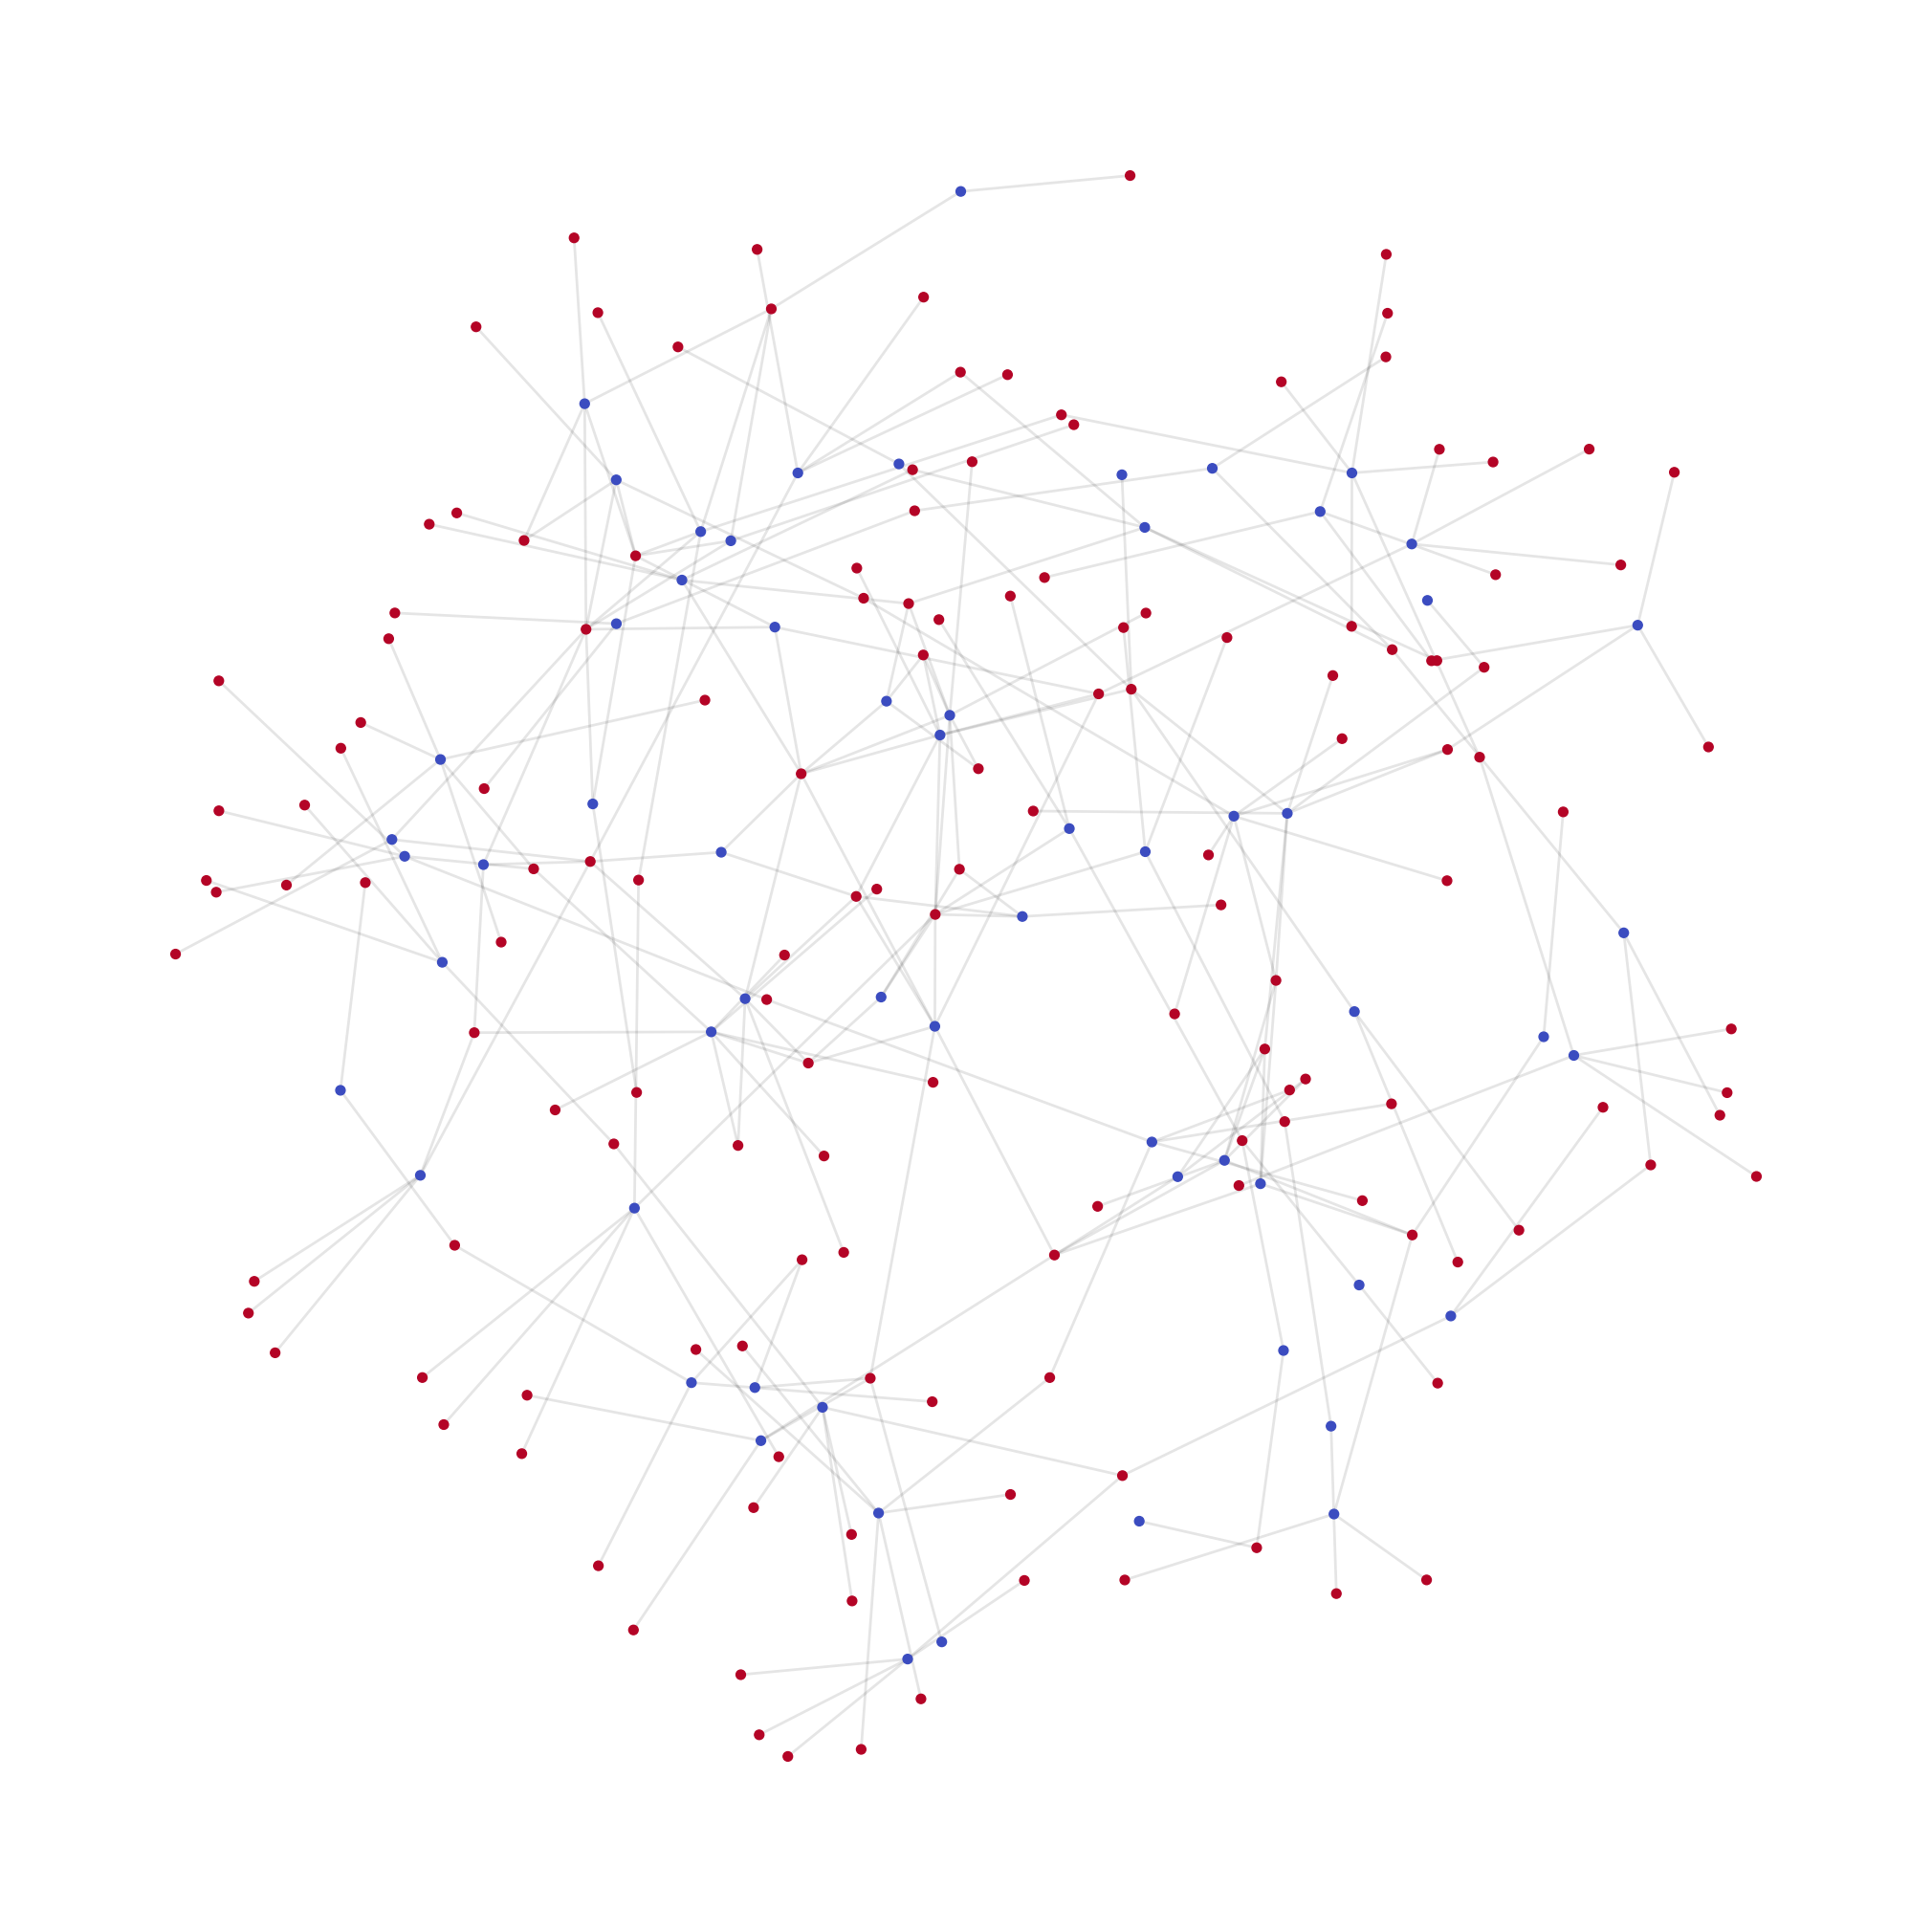

In [278]:
# Graph the large subgraph
color_map = {"user": 0, "track": 1}
node_color = [color_map[attr["node_type"]] for (id, attr) in sub_G_lg.nodes(data=True)]
plt.figure(figsize=(20,20))
nx.draw(sub_G_lg,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 50,
        width = 2,
        edge_color=(0, 0, 0, 0.1))

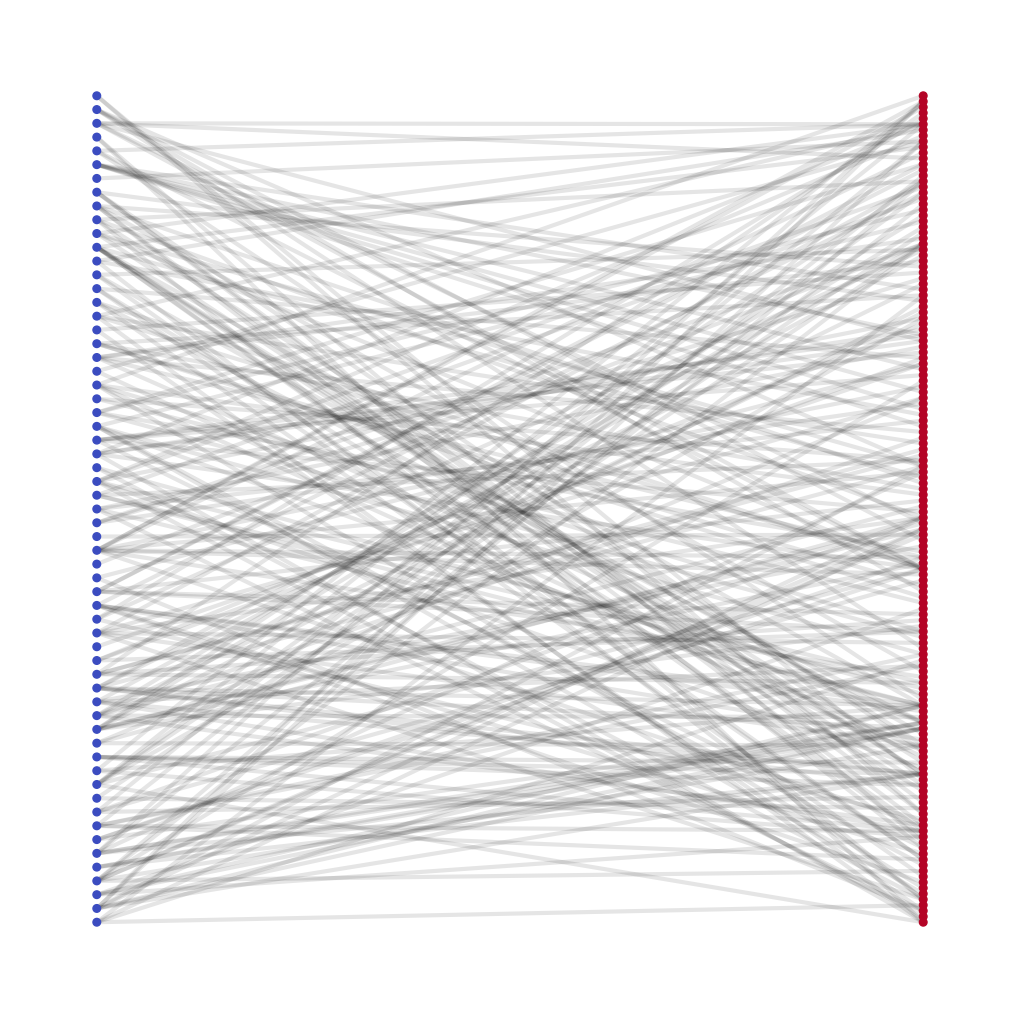

In [279]:
# Show the smaller subgraph as bipartite
top = nx.bipartite.sets(sub_G_lg)[0]
pos = nx.bipartite_layout(sub_G_lg, top)
plt.figure(figsize=(10,10))
nx.draw(sub_G_lg,
        pos=pos,
        cmap=plt.get_cmap('coolwarm'),
        node_color=node_color,
        node_size = 30,
        width = 3,
        edge_color=(0, 0, 0, 0.1))

## Constructing a graph dataset

In order to use our graph with the graph. machine learning packages we installed, we need to do a bit of processing of the graph first.

In [298]:
G.nodes()[0]

{'name': User -itssoeasy, 'node_type': 'user'}

In [302]:
n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

# by sorting them we get an ordering playlist1, ..., playlistN, track1, ..., trackN
sorted_nodes = list(G.nodes())

# create dictionaries to index to 0 to n_nodes, will be necessary for when we are using tensors
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

G = nx.relabel_nodes(G, node2id)



In [303]:
node2id.keys()


dict_keys([User -itssoeasy, User 0-172, User 40belowsummer, User 5Lighters, User 69dude, User A7X52969, User ACID_WIZRD, User AJRogers25, User AJ_Byers, User AMx93, User AORocker, User AStrangeMercy, User ASunShapedPool, User ATraceOfDesire, User Aaarhh, User AaronTrudeau, User Aaronjames20, User Abbreviated, User Aboutagirl1, User Abreulb, User Abstractioneer, User AceIverson3, User AceTB, User Acid_Borek, User Acidcomplex_, User Acquiescee, User AddyQG, User Adinnata, User AdonTomas, User Adonai767, User Aejir_1, User AerithLockhart, User AerysVengeance, User Afandreazzi, User Agaguess, User Agallochy, User AgentAsh, User AgentEmmy, User Agwen, User Aime_y, User AinsleyW46, User Airavis, User Airpodes, User Akkash12000, User Akrila_, User Al2MEDWITHAMIND, User AlJarryPleroma, User Alaninho100, User AlbumMinusBand, User AlessiCo, User AlexB709, User AlexCimmino, User AlexKomatose, User AlexMartinius, User Alex_Burk, User AlexanderPope, User Alexxx505, User Alldaychubbyfan, User Allesp

In [305]:
# also keep track of how many users, tracks we have
users_idx = [i for i, v in enumerate(node2id.keys()) if isinstance(v, User)] 
tracks_idx = [i for i, v in enumerate(node2id.keys()) if isinstance(v, Track)]
n_users = np.max(users_idx) + 1
n_tracks = n_nodes - n_users

n_users, n_tracks

(1629, 27873)

In [308]:
G.edges()

EdgeView([(0, 1648), (0, 1632), (0, 1630), (0, 1640), (0, 1650), (0, 1649), (0, 1656), (0, 1636), (0, 1654), (0, 1643), (0, 1635), (0, 1655), (0, 1647), (0, 1652), (0, 1645), (0, 1637), (0, 1646), (0, 1642), (0, 1638), (0, 1657), (0, 1651), (0, 1631), (0, 1629), (0, 1639), (0, 1641), (0, 1633), (0, 1653), (0, 1658), (0, 1644), (0, 1634), (1, 1671), (1, 1675), (1, 1676), (1, 1677), (1, 1663), (1, 1692), (1, 1678), (1, 1674), (1, 1672), (1, 1690), (1, 1688), (1, 1664), (1, 1660), (1, 1661), (1, 1662), (1, 1665), (1, 1666), (1, 1669), (1, 1670), (1, 1667), (1, 1679), (1, 1659), (1, 1681), (1, 1673), (1, 1668), (1, 1689), (1, 1687), (1, 1686), (1, 1685), (1, 1684), (1, 1683), (1, 1691), (1, 1682), (1, 1680), (2, 1703), (2, 1700), (2, 1699), (2, 1729), (2, 1698), (2, 1694), (2, 1713), (2, 1697), (2, 1712), (2, 1696), (2, 1695), (2, 1704), (2, 1693), (2, 1725), (2, 1707), (2, 1709), (2, 1728), (2, 1726), (2, 1708), (2, 1710), (2, 1711), (2, 1705), (2, 1714), (2, 1724), (2, 1701), (2, 1723), 

When training a machine learning model, it's important to evaluate its performance on data that the model hasn't seen before to ensure its generalizability to unseen data. A train/validation/test split is used to achieve this by dividing the dataset into three sets: the training set, used to train the model; the validation set, used to tune the model's hyperparameters and prevent overfitting; and the test set, used to evaluate the model's performance on unseen data. We use a 70%-15%-15% split.

How does it work to split a graph? There is an extremely useful PyG method `RandomLinkSplit`, which will help us with that. This function works by randomly removing a specified percentage of the edges in the graph. The split is performed such that the training split doesn't include edges in the validation and test splits; and the validation split doesn't include edges in the test split. Also, since we plan to implement our own negative samplign algorithm we set add_negative_train_samples and neg_sampling_ratio to zero.

In [309]:
# turn the graph into a torch_geometric Data object
num_nodes = G.number_of_nodes()
edge_idx = torch.Tensor(np.array(G.edges()).T)
graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes)

# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    neg_sampling_ratio=0,
    num_val=0.15, num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)

In [311]:
G.edges()

EdgeView([(0, 1648), (0, 1632), (0, 1630), (0, 1640), (0, 1650), (0, 1649), (0, 1656), (0, 1636), (0, 1654), (0, 1643), (0, 1635), (0, 1655), (0, 1647), (0, 1652), (0, 1645), (0, 1637), (0, 1646), (0, 1642), (0, 1638), (0, 1657), (0, 1651), (0, 1631), (0, 1629), (0, 1639), (0, 1641), (0, 1633), (0, 1653), (0, 1658), (0, 1644), (0, 1634), (1, 1671), (1, 1675), (1, 1676), (1, 1677), (1, 1663), (1, 1692), (1, 1678), (1, 1674), (1, 1672), (1, 1690), (1, 1688), (1, 1664), (1, 1660), (1, 1661), (1, 1662), (1, 1665), (1, 1666), (1, 1669), (1, 1670), (1, 1667), (1, 1679), (1, 1659), (1, 1681), (1, 1673), (1, 1668), (1, 1689), (1, 1687), (1, 1686), (1, 1685), (1, 1684), (1, 1683), (1, 1691), (1, 1682), (1, 1680), (2, 1703), (2, 1700), (2, 1699), (2, 1729), (2, 1698), (2, 1694), (2, 1713), (2, 1697), (2, 1712), (2, 1696), (2, 1695), (2, 1704), (2, 1693), (2, 1725), (2, 1707), (2, 1709), (2, 1728), (2, 1726), (2, 1708), (2, 1710), (2, 1711), (2, 1705), (2, 1714), (2, 1724), (2, 1701), (2, 1723), 

From this split, we obtain two  types of edges: message-passing (`edge_index` and supervision edges (`edge_label_index`). Message passing edges are used to propagate information between nodes in the graph. Supervision edges, on the other hand, are used to supervise the training process, indicating the presence or absence of user-song link. These are the edges that we wish to predict.


In the next line, we need to assign them to the right type as they are initially stored as floats.

In [312]:
# note these are stored as float32, we need them to be int64 for future training

# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 34998 positives supervision edges
Validation set has 7499 positive supervision edges
Test set has 7499 positive supervision edges
Train set has 69996 message passing edges
Validation set has 69996 message passing edges
Test set has 84994 message passing edges


We are now ready to get started implementing our model!

## Designing our model

To implement our model, we will be using the LightGCN architecture. This architecture forms a simple GNN method where we remove nonlinearity across layers. This leads to a highly scalable architecture with fewer parameters. By taking a weighted sum of the embeddings at different hop scales (also called multi-scale diffusion), LightGCN has exhibited better performance than other neural graph collaborative filtering approaches while also being computationally efficient.


To implement our models, we will customize the implementation of LightGCN from PyG.

One important note: the GNN method we are defining below acts as our full graph neural network, consisting of multiple message passing layers that are connected with skip connections (weighted according to the alpha parameter). We surface functionality to change the message passing layer from the default LightGCN layer to alternatives, such as a GAT and GraphSAGE convolution instead, as well as to have a learnable alpha parameter.

The three convolutional layers we use are the LGConv (from LightGCN), SAGEConv (GraphSAGE), and GATConv (GAT). We add a linear layer on top of the GATConv to take the concatenated outputs from the multiple attention heads back to the embedding dimension. Below we provide the update steps for each type of layer.

1. LGConv

\begin{equation*}
\mathbf{e}_i^{(k+1)} = \underset{j \in \mathcal{N}(i)}{\sum} \frac{1}{
  \sqrt{| \mathcal{N}(i)|} \sqrt{| \mathcal{N}(j)|} } \mathbf{e}_j^{(k)}
\end{equation*}


2. SAGEConv

\begin{equation*}
\mathbf{e}^{(k+1)}_{i} = \mathbf{W}_1 \mathbf{e}^{(k)}_{i} + \mathbf{W}_2 \frac{1}{| \mathcal{N}(i)|} \underset{j \in \mathcal{N}(i)}{\sum} \mathbf{e}^{(k)}_j
\end{equation*}

3. GATConv

\begin{align*}
    \mathbf{e}^{(k+1)}_i &= \mathbf{\Theta}\mathbf{x}_i^{(k+1)} + \mathbf{B} \\
    \mathbf{x}_i^{(k+1)} &= \underset{h=1}{\Big\Vert^H} \sum_{j \in \mathcal{N}(i) \cup \{i\} } \alpha_{ij}^h \mathbf{W}^h
    \mathbf{e}^{(k)}_j \\
    \alpha^h_{ij} &= \frac{
    \exp(
    \text{LeakyReLU}(\mathbf{a}^{h^{T}} \left[\mathbf{W}^h \mathbf{e}_i \Vert \mathbf{W}^h \mathbf{e}_j \right]))
    }{
    \underset{l \in \mathcal{N}(i) \cup \{i\}}{\sum}     \exp(
    \text{LeakyReLU}(\mathbf{a}^{h^{T}} \left[\mathbf{W}^h \mathbf{e}_i \Vert \mathbf{W}^h \mathbf{e}_l \right]))
    }
\end{align*}

No matter which convolutional layer we use, we still take the weighted sum of the different layers as is standard in LightGCN. We do so as follows:

\begin{equation*}
    \mathbf{e}_i = \sum_{k=1}^K \alpha_k \mathbf{e}^{(k)}_i
\end{equation*}


In [116]:
class GCN(torch.nn.Module):
    """
      Here we adapt the LightGCN model from Torch Geometric for our purposes. We allow
      for customizable convolutional layers, custom embeddings. In addition, we deifne some
      additional custom functions.

    """

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers
        self.conv_layer = conv_layer
        if conv_layer == "LGC":
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          # initialize Graph Attention layer with multiple heads
          # initialize linear layers to aggregate heads
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])

        elif conv_layer == "SAGE":
          #  initialize GraphSAGE conv
          self.convs = ModuleList(
              [SAGEConv(in_channels = embedding_dim, out_channels = embedding_dim, **kwargs) for _ in range(num_layers)]
          )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight

        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
              x = self.linears[i](x)
            out = out + x * weights[i + 1]

        return out

    def initialize_embeddings(self, data):
      # initialize with the data node features
        self.embedding.weight.data.copy_(data.node_feature)


    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:

        pred = self(edge_index, edge_label_index).sigmoid()
        return pred if prob else pred.round()

    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor:

        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)

    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')


Our main specifications will use a Bayesian Personalized Ranking, which is calculated as

\begin{equation*}
    \text{BPR Loss}(i) = \frac{1}{|\mathcal{E}(i)|} \underset{{(i, j_{+}) \in \mathcal{E}(i)}}{\sum} \log \sigma \left( \text{score}(i, j_+) - \text{score}(i, j_-) \right)
\end{equation*}

for a pair of positive edge $(i, j_{+})$ and negative edge $(i, j_{-})$. More on how we define a negative edge later.

In [117]:
class BPRLoss(_Loss):
    r"""The Bayesian Personalized Ranking (BPR) loss.

    The BPR loss is a pairwise loss that encourages the prediction of an
    observed entry to be higher than its unobserved counterparts
    (see `here <https://arxiv.org/abs/2002.02126>`__).

    .. math::
        L_{\text{BPR}} = - \sum_{u=1}^{M} \sum_{i \in \mathcal{N}_u}
        \sum_{j \not\in \mathcal{N}_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj})
        + \lambda \vert\vert \textbf{x}^{(0)} \vert\vert^2

    where :math:`lambda` controls the :math:`L_2` regularization strength.
    We compute the mean BPR loss for simplicity.

    Args:
        lambda_reg (float, optional): The :math:`L_2` regularization strength
            (default: 0).
        **kwargs (optional): Additional arguments of the underlying
            :class:`torch.nn.modules.loss._Loss` class.
    """
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        r"""Compute the mean Bayesian Personalized Ranking (BPR) loss.

        .. note::

            The i-th entry in the :obj:`positives` vector and i-th entry
            in the :obj:`negatives` entry should correspond to the same
            entity (*.e.g*, user), as the BPR is a personalized ranking loss.

        Args:
            positives (Tensor): The vector of positive-pair rankings.
            negatives (Tensor): The vector of negative-pair rankings.
            parameters (Tensor, optional): The tensor of parameters which
                should be used for :math:`L_2` regularization
                (default: :obj:`None`).
        """
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)

        return (-log_prob + regularization) / n_pairs

## Defining training, test functions

### Negative sampling

Important to any link prediction task is negative sampling. In the graph, we observe positive edges, which allows us to capture which nodes should be most similar to one another. Adding negative edges allows the model to explicitly capture that nodes that don't share an edge should have different embeddings. Without negative edges, you can convince yourself that a valid loss minimization strategy would be to simply assign all nodes the same embedding, which is obviously not meaningful or desirable.

Consequently, in this section, we define our negative sampling strategy. In particular, we take three approaches:
1. Random, no positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. For computational efficiency, we don't check if ($p_i$, $t_j$) is actually a negative edge, though probabilistically it is very likely.
2. Random, positive check: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the full set of track nodes such that ($p_i$, $t_j$) is the negative edge. We ensure that ($p_i$, $t_j$) is not a positive edge.
3. Hard: for each positive edge coming from a playlist $p_i$, randomly draw a track $t_j$ from the top $k$ proportion of tracks, ranked by dot product similarity to $p_i$. For epoch 0, $k = 1$ and we lower it at each subsequent iteration.

In [337]:
def sample_negative_edges_nocheck(data, num_users, num_tracks, device = None):
  # note computationally inefficient to check that these are indeed negative edges
  users = data.edge_label_index[0, :]
  tracks = torch.randint(num_users, num_users + num_tracks - 1, size = data.edge_label_index[1, :].size())

  if users.get_device() != -1: # on gpu
    tracks = tracks.to(device)

  neg_edge_index = torch.stack((users, tracks), dim = 0)
  neg_edge_label = torch.zeros(neg_edge_index.shape[1])

  if neg_edge_index.get_device() != -1: # on gpu
    neg_edge_label = neg_edge_label.to(device)

  return neg_edge_index, neg_edge_label

def sample_negative_edges(data, num_users, num_tracks, device=None):
    positive_users, positive_tracks = data.edge_label_index

    # Create a mask tensor with the shape (num_playlists, num_tracks)
    mask = torch.zeros(num_users, num_tracks, device=device, dtype=torch.bool)
    mask[positive_users, positive_tracks - num_users] = True

    # Flatten the mask tensor and get the indices of the negative edges
    flat_mask = mask.flatten()
    negative_indices = torch.where(~flat_mask)[0]

    # Sample negative edges from the negative_indices tensor
    sampled_negative_indices = negative_indices[
        torch.randint(0, negative_indices.size(0), size=(positive_users.size(0),), device=device)
    ]

    # Convert the indices back to playlists and tracks tensors
    playlists = torch.floor_divide(sampled_negative_indices, num_tracks)
    tracks = torch.remainder(sampled_negative_indices, num_tracks)
    tracks = tracks + num_users

    neg_edge_index = torch.stack((playlists, tracks), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)

    return neg_edge_index, neg_edge_label

def sample_hard_negative_edges(data, model, num_users, num_tracks, device=None, batch_size=500, frac_sample = 1):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        user_embeddings = embeddings[:num_users].to(device)
        tracks_embeddings = embeddings[num_users:].to(device)

    positive_users, positive_tracks = data.edge_label_index
    num_edges = positive_users.size(0)

    # Create a boolean mask for all the positive edges
    positive_mask = torch.zeros(num_users, num_tracks, device=device, dtype=torch.bool)
    positive_mask[positive_users, positive_tracks - num_users] = True

    neg_edges_list = []
    neg_edge_label_list = []

    for batch_start in range(0, num_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_edges)

        batch_scores = torch.matmul(
            user_embeddings[positive_users[batch_start:batch_end]], tracks_embeddings.t()
        )

        # Set the scores of the positive edges to negative infinity
        batch_scores[positive_mask[positive_users[batch_start:batch_end]]] = -float("inf")

        # Select the top k highest scoring negative edges for each playlist in the current batch
        # do 0.99 to filter out all pos edges which will be at the end
        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_tracks), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_tracks), size = (batch_end - batch_start, ))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + n_users

        # Create the negative edges tensor for the current batch
        neg_edges_batch = torch.stack(
            (positive_users[batch_start:batch_end], top_indices_selected), dim=0
        )
        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)

        neg_edges_list.append(neg_edges_batch)
        neg_edge_label_list.append(neg_edge_label_batch)

    # Concatenate the batch tensors
    neg_edges = torch.cat(neg_edges_list, dim=1)
    neg_edge_label = torch.cat(neg_edge_label_list)

    return neg_edges, neg_edge_label

### Evaluation

In addition, to calculating the loss, we would like to have other metrics to evaluate the quality of our predictions.

First, we consider one common metric for recommender systems: Recall@K. This is defined as follows: for a playlist $i$, $P^k_i$ represents the set of the top $k$ predicted tracks for $i$ and $R_i$ the ground truth of connected tracks to playlist $i$, then we calculate
$$
\text{recall}^k_i = \frac{| P^k_i \cap R_i | }{|R_i|}.
$$
If $R_i = 0$, then we assign this value to 1. Note, if $R_i \subset P_i^k$, then the recall is equal to 1. Hence, our choice of $k$ matters a lot.

Note: when evaluating this metric on our validation or test set, we need to make sure to filter the message passing edges from consideration, as the model can directly observe these.

We choose a value of $k = 300$, which seems reasonable given the overall number of possible tracks is 12,247.

In [119]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        playlists_embeddings = embeddings[:n_users]
        tracks_embeddings = embeddings[n_users:]

    hits_list = []
    relevant_counts_list = []

    for batch_start in range(0, n_users, batch_size):
        batch_end = min(batch_start + batch_size, n_users)
        batch_playlists_embeddings = playlists_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_playlists_embeddings, tracks_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices] - n_users] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices] - n_users] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In addition, we calculate the ROC AUC score for the binary predictions, which provides a measure of the efficiency of our model at distinguishing `true' track-playlist edges from non-existing ones. The higher this score, the better (a perfect score is achieved when ROC AUC = 1).

In [120]:
def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc

### Main train / test functions

Now we define our main train and test functions, which will handle model training and evaluation.

In [331]:
# Train
def train(datasets, model, optimizer, loss_fn, args, K = 300, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [],
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch
    model.train()
    optimizer.zero_grad()

    # obtain negative sample
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(train_data, n_users, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            train_data, model, n_users, n_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    # calculate loss function
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0:
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = K, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

    if epoch % 20 == 0:

      # save embeddings for future visualization
      path = os.path.join("model_embeddings", model.name)
      if not os.path.exists(path):
        os.makedirs(path)
      torch.save(model.embedding.weight, os.path.join("model_embeddings", model.name, f"{model.name}_{loss_fn}_{neg_samp}_{epoch}.pt"))

  pickle.dump(stats, open(f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pkl", "wb"))
  return stats

def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):

  model.eval()
  with torch.no_grad(): # want to save RAM

    # conduct negative sampling
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, n_users, n_tracks, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0 or neg_edge_index is None:
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            data, model, n_users, n_tracks, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding
    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)
    # concatenate pos, neg scores together and evaluate loss
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss
    if loss_fn == "BCE":
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)

  return loss, roc, neg_edge_index, neg_edge_label

## Training models

### Set up hyperparameters and arguments

Run through these cells to set up all the hyperparameters and arguments we will need to run our models.

In [322]:
# create a dictionary of the dataset splits
datasets = {
    'train':train_split,
    'val':val_split,
    'test': test_split
}

In [373]:
# initialize our arguments
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301
}

In [374]:
# initialize model and and optimizer
num_nodes = n_users + n_tracks
model = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'],
    embedding_dim = args["emb_size"], conv_layer = "SAGE"
)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [375]:
# send data, model to GPU if available
users_idx = torch.Tensor(users_idx).type(torch.int64).to(args["device"])
tracks_idx =torch.Tensor(tracks_idx).type(torch.int64).to(args["device"])
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])

GCN(29502, 64, num_layers=3)

In [376]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [377]:
train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

Beginning training for LGCN_SAGE_3_e64_nodes29502_
Epoch 0; Train loss 0.6909710764884949; Val loss 0.7352048754692078; Train ROC 0.613686325821118; Val ROC 0.4571134176738078
Val recall 0.02862679585814476
Epoch 1; Train loss 0.6538375020027161; Val loss 1.0334968566894531; Train ROC 0.7121316763968726; Val ROC 0.45883088007769396
Epoch 2; Train loss 0.547923743724823; Val loss 3.018486738204956; Train ROC 0.7214512794231136; Val ROC 0.46931008323446105
Epoch 3; Train loss 0.7430175542831421; Val loss 1.7763516902923584; Train ROC 0.7102637310867733; Val ROC 0.4664622305243668
Epoch 4; Train loss 0.5070635080337524; Val loss 1.2188193798065186; Train ROC 0.720960431899285; Val ROC 0.4487343211748142
Epoch 5; Train loss 0.5288234949111938; Val loss 1.0321182012557983; Train ROC 0.7136340574804171; Val ROC 0.45609230984098315
Epoch 6; Train loss 0.544776976108551; Val loss 0.9863382577896118; Train ROC 0.7285336369755445; Val ROC 0.4737858277978869
Epoch 7; Train loss 0.5391265749931335

{'train': {'loss': [tensor(0.6910, grad_fn=<DivBackward0>),
   tensor(0.6538, grad_fn=<DivBackward0>),
   tensor(0.5479, grad_fn=<DivBackward0>),
   tensor(0.7430, grad_fn=<DivBackward0>),
   tensor(0.5071, grad_fn=<DivBackward0>),
   tensor(0.5288, grad_fn=<DivBackward0>),
   tensor(0.5448, grad_fn=<DivBackward0>),
   tensor(0.5391, grad_fn=<DivBackward0>),
   tensor(0.5188, grad_fn=<DivBackward0>),
   tensor(0.5000, grad_fn=<DivBackward0>),
   tensor(0.4938, grad_fn=<DivBackward0>),
   tensor(0.4736, grad_fn=<DivBackward0>),
   tensor(0.4813, grad_fn=<DivBackward0>),
   tensor(0.4830, grad_fn=<DivBackward0>),
   tensor(0.4592, grad_fn=<DivBackward0>),
   tensor(0.4549, grad_fn=<DivBackward0>),
   tensor(0.4522, grad_fn=<DivBackward0>),
   tensor(0.4486, grad_fn=<DivBackward0>),
   tensor(0.4490, grad_fn=<DivBackward0>),
   tensor(0.4425, grad_fn=<DivBackward0>),
   tensor(0.4202, grad_fn=<DivBackward0>),
   tensor(0.3844, grad_fn=<DivBackward0>),
   tensor(0.3395, grad_fn=<DivBackwar

In [378]:
test(model, datasets['test'], "BPR", neg_samp = "random")
#loss, roc, neg_edge_index, neg_edge_label

(tensor(2.5737),
 0.6071918181347592,
 tensor([[  680,  1268,  1349,  ...,  1235,   653,  1033],
         [12977, 16261, 28864,  ...,  4410, 17587, 10062]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

### Comparison of approaches

We define a helper function `init_model` to make training different specifications more straightforward. Simply pass in your args, the convolutional layer you want and train away!

In [379]:
def init_model(conv_layer, args, alpha = False):
  num_nodes = n_users + n_tracks
  model = GCN(
      num_nodes = num_nodes, num_layers = args['num_layers'],
      embedding_dim = args["emb_size"], conv_layer = conv_layer,
      alpha_learnable = alpha
  )
  model.to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  return model, optimizer

In [380]:
## For example:

# using BPR loss
loss_fn = "BPR"

# using hard sampling
neg_samp = "hard"

args['epochs'] = 301
args['num_layers'] = 4
# for LGConv:
model, optimizer = init_model("LGC", args)
lgc_stats_hard = train(datasets, model, optimizer, loss_fn, args, K = 30, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes29502_
Epoch 0; Train loss 0.693047285079956; Val loss 0.6931036114692688; Train ROC 0.9390689615496661; Val ROC 0.5896580049851871
Val recall 0.04751557856798172
Epoch 1; Train loss 0.6922614574432373; Val loss 0.6928111910820007; Train ROC 0.9964246689534325; Val ROC 0.6276933559581515
Epoch 2; Train loss 0.6892712116241455; Val loss 0.6920586824417114; Train ROC 0.9984780407606485; Val ROC 0.6387495040677602
Epoch 3; Train loss 0.6832390427589417; Val loss 0.6906845569610596; Train ROC 0.9987181049304634; Val ROC 0.6436569993125811
Epoch 4; Train loss 0.6736705899238586; Val loss 0.6885601878166199; Train ROC 0.9986237361865888; Val ROC 0.6452892745569614
Epoch 5; Train loss 0.6635622382164001; Val loss 0.6857072114944458; Train ROC 0.9962502796360392; Val ROC 0.6423527493135459
Epoch 6; Train loss 0.647577166557312; Val loss 0.6818472743034363; Train ROC 0.9963589867532323; Val ROC 0.6445629119842995
Epoch 7; Train loss 0.6275920867919922;

In [381]:
# for LGConv:
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats_hard = train(datasets, model, optimizer, loss_fn, args, K = 300, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes29502_
Epoch 0; Train loss 0.6930475234985352; Val loss 0.6930999755859375; Train ROC 0.9356343306642904; Val ROC 0.5982231333115829
Val recall 0.0971720740199089
Epoch 1; Train loss 0.692263662815094; Val loss 0.6927729845046997; Train ROC 0.9968060917270346; Val ROC 0.6300767381510316
Epoch 2; Train loss 0.6892609596252441; Val loss 0.6919097900390625; Train ROC 0.9985757098816985; Val ROC 0.6390268313501053
Epoch 3; Train loss 0.6831621527671814; Val loss 0.6903102993965149; Train ROC 0.9984485247344235; Val ROC 0.6415679711644355
Epoch 4; Train loss 0.6734359860420227; Val loss 0.6878198981285095; Train ROC 0.9979410108161226; Val ROC 0.6429417952708848
Epoch 5; Train loss 0.6630574464797974; Val loss 0.6845374703407288; Train ROC 0.9951668056098925; Val ROC 0.6425576572853622
Epoch 6; Train loss 0.6466656923294067; Val loss 0.680056631565094; Train ROC 0.9946134791090785; Val ROC 0.6439842332358098
Epoch 7; Train loss 0.6261337399482727; 

In [382]:
# for GATConv:
model, optimizer = init_model("GAT", args)
gat_stats_hard = train(datasets, model, optimizer, loss_fn, args,  K = 300, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_4_e64_nodes29502_
Epoch 0; Train loss 0.6931449770927429; Val loss 0.6930707693099976; Train ROC 0.5050857808073224; Val ROC 0.5381296605649567
Val recall 0.08072727173566818
Epoch 1; Train loss 0.6927669048309326; Val loss 0.6930030584335327; Train ROC 0.5898589362380715; Val ROC 0.5083641858564206
Epoch 2; Train loss 0.6835833191871643; Val loss 4.066586971282959; Train ROC 0.6024480206637558; Val ROC 0.48706723593727685
Epoch 3; Train loss 3.3217434883117676; Val loss 0.697316586971283; Train ROC 0.6330711807616505; Val ROC 0.5020713434325359
Epoch 4; Train loss 0.6562502384185791; Val loss 0.6930800676345825; Train ROC 0.7175173771940715; Val ROC 0.5051726326100715
Epoch 5; Train loss 0.6899158954620361; Val loss 0.6930456757545471; Train ROC 0.6395209741863691; Val ROC 0.5090279006130008
Epoch 6; Train loss 0.6910479664802551; Val loss 0.692908525466919; Train ROC 0.6521038799467567; Val ROC 0.5350824213553406
Epoch 7; Train loss 0.6905069351196289;

In [383]:
# for SAGEConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats_hard = train(datasets, model, optimizer, loss_fn, args,  K = 300, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes29502_
Epoch 0; Train loss 0.6911936402320862; Val loss 0.7408047914505005; Train ROC 0.60986909937505; Val ROC 0.4756252960678351
Val recall 0.022616375237703323
Epoch 1; Train loss 0.647875189781189; Val loss 1.0925272703170776; Train ROC 0.7959890594158057; Val ROC 0.472890104509823
Epoch 2; Train loss 0.5097497701644897; Val loss 3.3075010776519775; Train ROC 0.7745673835391232; Val ROC 0.4689539527170987
Epoch 3; Train loss 0.5221160054206848; Val loss 2.6732146739959717; Train ROC 0.7536703206777254; Val ROC 0.475308447135975
Epoch 4; Train loss 0.36725950241088867; Val loss 2.3138461112976074; Train ROC 0.7833489626296917; Val ROC 0.4616595365580237
Epoch 5; Train loss 0.5459573268890381; Val loss 1.678340196609497; Train ROC 0.6875736682149024; Val ROC 0.4411096036079025
Epoch 6; Train loss 0.5010363459587097; Val loss 1.298877477645874; Train ROC 0.7028378122304988; Val ROC 0.4434919099583549
Epoch 7; Train loss 0.48173362016677856; 

In [384]:
# using random sampling
neg_samp = "random"

# for LGConv:
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats = train(datasets, model, optimizer, loss_fn, args,  K = 300, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes29502_
Epoch 0; Train loss 0.6930475234985352; Val loss 0.6930989623069763; Train ROC 0.935859055121862; Val ROC 0.5980863590631038
Val recall 0.08905711024999619
Epoch 1; Train loss 0.692340075969696; Val loss 0.6928027272224426; Train ROC 0.9859761311954799; Val ROC 0.6296707632316038
Epoch 2; Train loss 0.6897323131561279; Val loss 0.6920114755630493; Train ROC 0.9928298781319337; Val ROC 0.6449422664720855
Epoch 3; Train loss 0.6844744086265564; Val loss 0.6905714273452759; Train ROC 0.9952793094875193; Val ROC 0.6519762309597896
Epoch 4; Train loss 0.6761468052864075; Val loss 0.6883751749992371; Train ROC 0.9958179138976931; Val ROC 0.6517723010265439
Epoch 5; Train loss 0.6643940210342407; Val loss 0.6850889325141907; Train ROC 0.9956736892520822; Val ROC 0.6541583950536427
Epoch 6; Train loss 0.6490952372550964; Val loss 0.6810429692268372; Train ROC 0.9956986868027411; Val ROC 0.6540243770956811
Epoch 7; Train loss 0.6301887035369873;

In [385]:
# for GATConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("GAT", args)
gat_stats = train(datasets, model, optimizer, loss_fn, args,  K = 300, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_3_e64_nodes29502_
Epoch 0; Train loss 0.6931439638137817; Val loss 0.6930127143859863; Train ROC 0.5045289441094364; Val ROC 0.5219078417016477
Val recall 0.08678093552589417
Epoch 1; Train loss 0.6923741698265076; Val loss 0.6984573602676392; Train ROC 0.5680942913701343; Val ROC 0.48345671764102927
Epoch 2; Train loss 0.682597279548645; Val loss 0.6923064589500427; Train ROC 0.5663375604025356; Val ROC 0.493380377107133
Epoch 3; Train loss 0.6768834590911865; Val loss 0.8852748870849609; Train ROC 0.7002247927919116; Val ROC 0.5104968434160781
Epoch 4; Train loss 0.5353222489356995; Val loss 0.7350841164588928; Train ROC 0.728984370119085; Val ROC 0.5814748896332376
Epoch 5; Train loss 0.5094516277313232; Val loss 6.6754655838012695; Train ROC 0.7607209113344515; Val ROC 0.5851708707180427
Epoch 6; Train loss 2.206838846206665; Val loss 0.7739406228065491; Train ROC 0.7625186024932855; Val ROC 0.5865691991363172
Epoch 7; Train loss 0.5236771106719971; 

In [386]:
# for SAGEConv:
args['epochs'] = 301
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats = train(datasets, model, optimizer, loss_fn, args,  K = 300, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes29502_
Epoch 0; Train loss 0.6904904842376709; Val loss 0.7620309591293335; Train ROC 0.6190201513021238; Val ROC 0.45429755571623437
Val recall 0.01686622016131878
Epoch 1; Train loss 0.6356826424598694; Val loss 1.394276738166809; Train ROC 0.7104704347093695; Val ROC 0.45894346120843843
Epoch 2; Train loss 0.5323777794837952; Val loss 2.911046028137207; Train ROC 0.7177115606103177; Val ROC 0.46829723538192874
Epoch 3; Train loss 0.5362595319747925; Val loss 2.3120954036712646; Train ROC 0.7051352392758837; Val ROC 0.43962080662184033
Epoch 4; Train loss 0.5075132846832275; Val loss 2.014287233352661; Train ROC 0.7043797745721805; Val ROC 0.4549724290037801
Epoch 5; Train loss 0.5009423494338989; Val loss 2.049400806427002; Train ROC 0.7176659464178243; Val ROC 0.4795019742242025
Epoch 6; Train loss 0.48539191484451294; Val loss 2.271796226501465; Train ROC 0.7340369389675981; Val ROC 0.4908049614865304
Epoch 7; Train loss 0.46962761878967

## Training visualizations

Define some helper functions for our visualizations.

In [355]:
def detach_loss(stats):
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()

In [388]:
# If you had to stop for whatever reason, you can always reload the stats here! (just uncomment and change to correct paths)
gat_stats_random = pickle.load(open(f"model_stats/LGCN_GAT_3_e64_nodes29502__BPR_random.pkl", "rb"))
gat_stats_hard = pickle.load(open(f"model_stats/LGCN_GAT_4_e64_nodes29502__BPR_hard.pkl", "rb"))
lgc_stats_random = pickle.load(open(f"model_stats/LGCN_LGC_4_e64_nodes29502__BPR_random.pkl", "rb"))
lgc_stats_hard = pickle.load(open(f"model_stats/LGCN_LGC_4_e64_nodes29502__BPR_hard.pkl", "rb"))
sage_stats_hard = pickle.load(open(f"model_stats/LGCN_SAGE_3_e64_nodes29502__BPR_hard.pkl", "rb"))
sage_stats_random = pickle.load(open(f"model_stats/LGCN_SAGE_3_e64_nodes29502__BPR_random.pkl", "rb"))

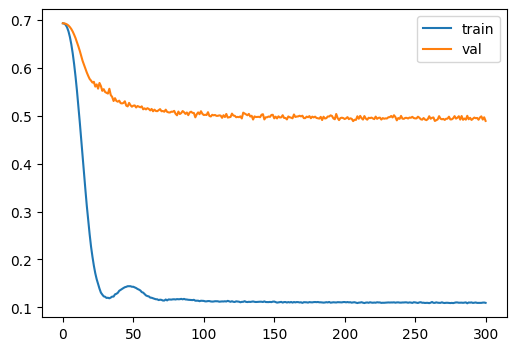

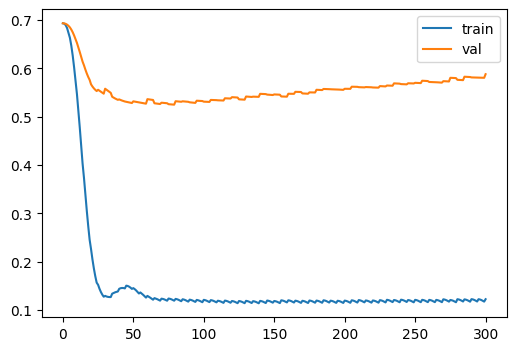

In [389]:
plot_train_val_loss(lgc_stats_random)

plot_train_val_loss(lgc_stats_hard)

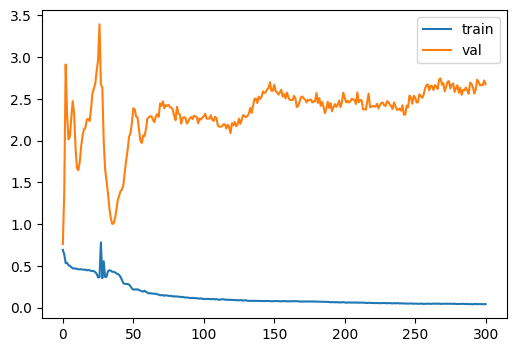

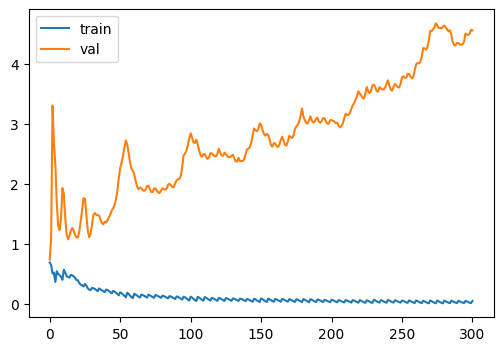

In [390]:
plot_train_val_loss(sage_stats_random)
plot_train_val_loss(sage_stats_hard)

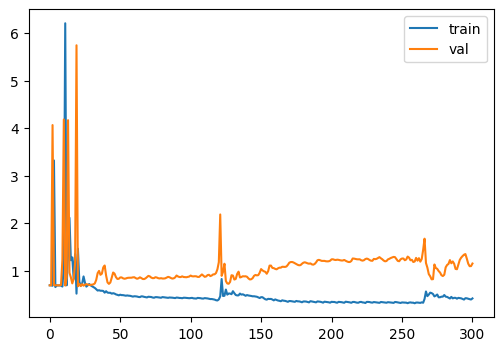

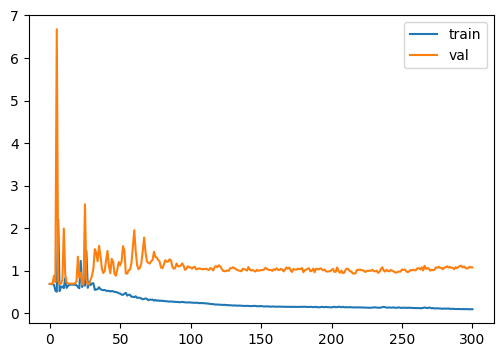

In [391]:
plot_train_val_loss(gat_stats_hard)
plot_train_val_loss(gat_stats_random)

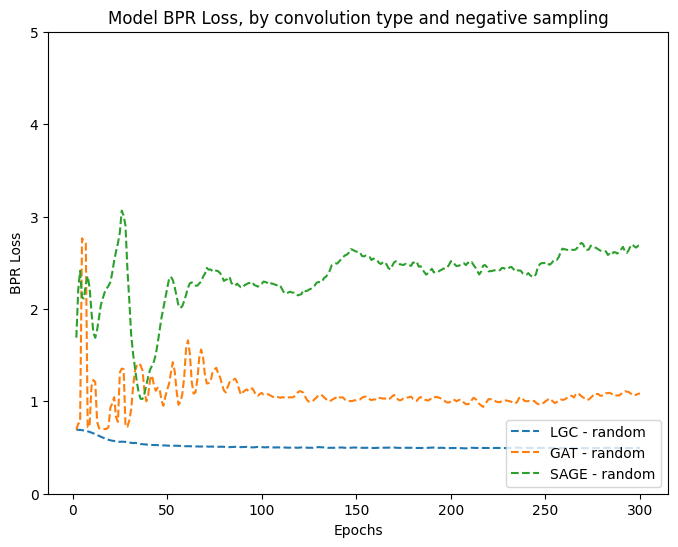

In [394]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats_random["val"][key])).rolling(3).mean()
gat_loss = pd.Series(detach_loss(gat_stats_random["val"][key])).rolling(3).mean()
sage_loss = pd.Series(detach_loss(sage_stats_random["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, sage_loss, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 5)
plt.show()

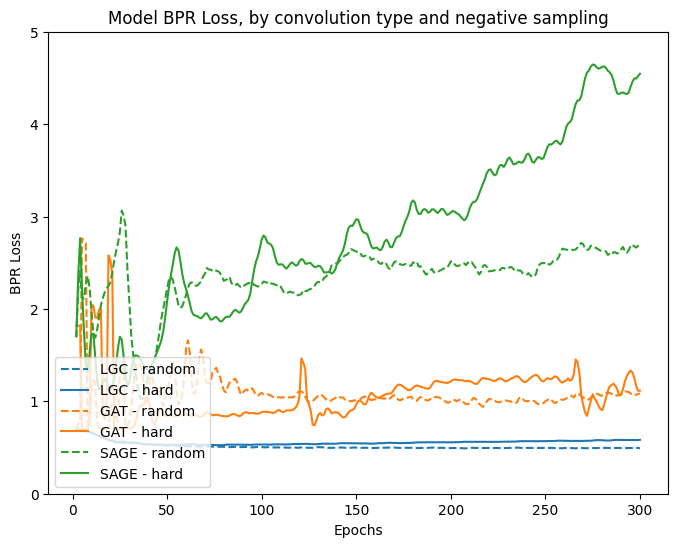

In [396]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats_random["val"][key])).rolling(3).mean()
gat_loss = pd.Series(detach_loss(gat_stats_random["val"][key])).rolling(3).mean()
sage_loss = pd.Series(detach_loss(sage_stats_random["val"][key])).rolling(3).mean()
lgc_hard_loss = pd.Series(detach_loss(lgc_stats_hard["val"][key])).rolling(3).mean()
gat_hard_loss = pd.Series(detach_loss(gat_stats_hard["val"][key])).rolling(3).mean()
sage_hard_loss = pd.Series(detach_loss(sage_stats_hard["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_loss, color = colors[0], label = "LGC - hard")
ax.plot(idx, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, gat_hard_loss, color = colors[1], label = "GAT - hard")
ax.plot(idx, sage_loss, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx, sage_hard_loss, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower left')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 5)
plt.show()

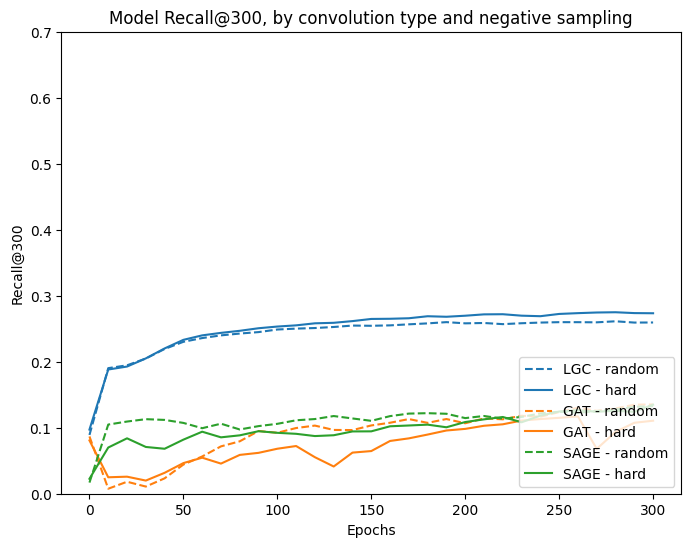

In [397]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "recall"
lgc_recall = lgc_stats_random["val"][key]
gat_recall = gat_stats_random["val"][key]
sage_recall = sage_stats_random["val"][key]
lgc_hard_recall = lgc_stats_hard["val"][key]
gat_hard_recall = gat_stats_hard["val"][key]
sage_hard_recall = sage_stats_hard["val"][key]
# increment by 10
idx = np.arange(0, 10 * len(lgc_recall), 10)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_recall, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_recall, color = colors[0], label = "LGC - hard")
ax.plot(idx, gat_recall, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx, gat_hard_recall, color = colors[1], label = "GAT - hard")
ax.plot(idx, sage_recall, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx, sage_hard_recall, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@300")
ax.set_title("Model Recall@300, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()

Since the result from the model with the 'LGC' convolutional layer is the best, we will be using that for the full dataset. In addition, to uniform the evaluation metrics, we will be using recall@30 instead. The full model code can be found in GCN_full.ipynb file